This notebook walks through the process of creating a MapMyCells-ready h5ad file from real data, submitting it to the on-line MapMyCells tool, downloading the results, and inspecting their contents.

# 1 -- Set up environment

#### You only need to run the first two cells if your environment has never been set up and had the necessary libraries installed
The cell below will install the python libraries necessary to run this notebook

In [1]:
! pip install anndata matplotlib "numpy<2.0.0" pandas scipy umap-learn

  Using cached anndata-0.10.9-py3-none-any.whl.metadata (6.9 kB)
  Using cached matplotlib-3.9.2-cp310-cp310-macosx_10_12_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (89 kB)
  Using cached scipy-1.14.1-cp310-cp310-macosx_10_13_x86_64.whl.metadata (60 kB)
  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
  Using cached array_api_compat-1.9-py3-none-any.whl.metadata (1.5 kB)
  Using cached h5py-3.12.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata (2.5 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached contourpy-1.3.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp310-cp310-macosx_10_9_universal2.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.3 kB)
  Using

After installing the libraries, you need to restart the kernel so that you can import the libraries into this notebook.

In [2]:
from IPython import get_ipython

get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

#### The cell below is the first cell you need to run if you have already set up your python environment

If you get an import error, run the two cells above, then re-run this cell.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import anndata
import datetime
import hashlib
import json
import numpy as np
import pandas as pd
import pathlib
import scipy.sparse
import subprocess
import tempfile
import umap

Let's define (and create, if necessary) a directory in which we can store all of the data generated and consumed by this notebook.

In [2]:
parent_data_dir = pathlib.Path('data')
if not parent_data_dir.exists():
    parent_data_dir.mkdir()

assert parent_data_dir.is_dir()

# 2 -- Downloading example data and writing it to an h5ad file

The cell below downloads the data from the NEMO archive (if necessary). It will also validate that the file has the expected md5 checksum. The data in question is taken from Langlieb et al. 2023 (https://doi.org/10.1101/2023.03.06.531307)

In [3]:
data_url = "https://data.nemoarchive.org/biccn/grant/u19_huang/macosko_regev/transcriptome/sncell/10X_v2/mouse/processed/counts/pBICCNsMMrMOPi70470511Bd180328.mex.tar.gz"
data_dst = parent_data_dir / "downloaded_file.tar.gz"

if not data_dst.exists():
    args = [
        "curl",
        "-o",
        str(data_dst.resolve().absolute()),
        data_url
    ]

    process = subprocess.Popen(args)
    process.wait()

assert data_dst.is_file()

expected_hash = "81ffc75a15bc40e32888bb2db9eecb52"
hasher = hashlib.md5()
with open(data_dst, "rb") as src:
    hasher.update(src.read())

assert hasher.hexdigest() == expected_hash
print(f"=======FILE SUCCESSFULLLY DOWNLOADED TO {data_dst}=======")

=======FILE SUCCESSFULLLY DOWNLOADED TO data/downloaded_file.tar.gz=======


The cell below will untar the downloaded file.

In [4]:
data_dir = parent_data_dir / 'untarred_data'
if not data_dir.exists():
    data_dir.mkdir()

args = [
    "tar",
    "-xvf",
    str(data_dst.resolve().absolute()),
    "--directory",
    str(data_dir.resolve().absolute())
]
process = subprocess.Popen(args)
process.wait()
print(f"=======FILE SUCCESSFULLY UNTARRED TO {data_dir}=======")

x pBICCNsMMrMOPi70470511Bd180328/matrix.mtx

=======FILE SUCCESSFULLY UNTARRED TO data/untarred_data=======



x pBICCNsMMrMOPi70470511Bd180328/genes.tsv
x pBICCNsMMrMOPi70470511Bd180328/barcodes.tsv


Now let's write the data into an h5ad file that is suited for submission to MapMyCells.

In [5]:
# only use wells with this many non-zero gene counts (or more)
min_genes = 100  

# define a path to the h5ad file we will create (delete it if it already exists)
h5ad_path = parent_data_dir / f"example_h5ad_min_genes_{min_genes:04}.h5ad"

if h5ad_path.exists():
    h5ad_path.unlink()

# find the directory into which the raw data was untarred
actual_data_dir = [n for n in data_dir.iterdir() if n.is_dir()][0]
print(f"======DATA FOUND IN {actual_data_dir}=======")

======DATA FOUND IN data/untarred_data/pBICCNsMMrMOPi70470511Bd180328=======


## Create the var DataFrame

h5ad files store metadata about the genes in the cell-by-gene matrix in a DataFrame referred to as `var`. Each row in this DataFrame represents a gene (column) in the final cell-by-gene matrix. All that MapMyCells requires is that the index of this DataFrame contain the unique identifiers of each gene. Ideally, these identifiers would be EnsemblID, but MapMyCells can handle some common gene symbols. In order to exercise the full functionality of MapMyCells, we will make our lives difficult by using gene symbols as the index in our `var` DataFrame, even though the data we downloaded does contain EnsemblIDs.

In [6]:
gene_file_path = actual_data_dir / 'genes.tsv'
assert gene_file_path.is_file()

# Assemble a list of gene identifiers to serve as the index of 'var' in the h5ad file.
# We are going to make things more difficult on ourselves, identifying the genes
# by their symbols, rather than their EnsemblIDs (which are available in the .tsv
# file). MapMyCells prefers to work in EnsemblID, but can map common gene symbols
# to EnsemblID. We are using the gene symbols here to showcase that functionality.
#
# In "actual" production, it is best practice to identify all genes using
# EnsemblID.

gene_symbols = []
gene_identifiers = []
symbol_to_ct = dict()

with open(gene_file_path, 'r') as src:
    for line in src:
        line = line.split()
        identifier = line[0]
        symbol = line[1]
        gene_identifiers.append(identifier)
        gene_symbols.append(symbol)
        if symbol not in symbol_to_ct:
            symbol_to_ct[symbol] = 0
        symbol_to_ct[symbol] += 1

# in cases where a symbol maps to more than one EnsemblID,
# just use the EnsemblID
gene_list = []
for symbol, identifier in zip(gene_symbols, gene_identifiers):
    if symbol_to_ct[symbol] == 1:
        gene_list.append(symbol)
    else:
        gene_list.append(identifier)

assert len(set(gene_list)) == len(gene_list)

print(f"=======READ GENES FROM {gene_file_path}=======")

var = pd.DataFrame([{'gene_id': g} for g in gene_list]).set_index('gene_id')

=======READ GENES FROM data/untarred_data/pBICCNsMMrMOPi70470511Bd180328/genes.tsv=======


## Create the obs DataFrame

h5ad files contain metadata about the cells in the cell-by-gene matrix in a DataFrame referred to as `obs`. Each row in this DataFrame represents a cell (row) in the final cell-by-gene matrix. Because we only want to include wells with a significant number of non-zero genes, we will scan through the raw cell-by-gene data and only select wells with at least `min_genes` non-zero genes to include in our `obs` DataFrame.

In [7]:
barcode_file_path = actual_data_dir / 'barcodes.tsv'
assert barcode_file_path.is_file()
with open(barcode_file_path, 'r') as src:
    cell_list = [c.strip() for c in src]
print(f"=======READ CELL BARCODES FROM {barcode_file_path}=======")

# Identify the wells that pass our cut on min_genes.

matrix_file_path = actual_data_dir / 'matrix.mtx'

with open(matrix_file_path, 'r') as src:
    src.readline()
    src.readline()
    src.readline()
    cell_idx = np.array(
        [int(r.strip().split()[1])-1 for r in src])

unq_idx, ct = np.unique(cell_idx, return_counts=True)
valid_cell_idx = np.sort(unq_idx[(ct>=min_genes)])
cell_list = [cell_list[ii] for ii in valid_cell_idx]

# dict mapping old cell idx to new cell idx
cell_idx_transform = {old:new for new, old in enumerate(valid_cell_idx)}

valid_cells = set(valid_cell_idx)

print(f"======={len(valid_cells)} CELLS PASSED gene ct>={min_genes}=======")

obs = pd.DataFrame([{'barcode': c} for c in cell_list]).set_index('barcode')


=======READ CELL BARCODES FROM data/untarred_data/pBICCNsMMrMOPi70470511Bd180328/barcodes.tsv=======
=======14493 CELLS PASSED gene ct>=100=======


## Create the cell-by-gene matrix and write out the h5ad file

Now we will read in the actual cell-by-gene matrix, store it one of `scipy`'s sparse matrix formats, and write the data out to an h5ad file using the `anndata` library.

In [8]:

# Put together the cell-by-gene matrix

row_idx = []
col_idx = []
counts = []
with open(matrix_file_path, 'r') as src:
    src.readline()
    src.readline()
    src.readline()
    for line in src:
        params = line.strip().split()
        this_gene = int(params[0])-1
        this_cell = int(params[1])-1
        this_ct = int(params[2])
        if this_cell in valid_cells:
            row_idx.append(cell_idx_transform[this_cell])
            col_idx.append(this_gene)
            counts.append(this_ct)

print(f"=======READ MATRIX FROM {matrix_file_path}=======")

X_data = scipy.sparse.csr_matrix(
    (
     counts,
     (row_idx, col_idx)
    ),
    shape=(len(obs), len(var))
)

a_data = anndata.AnnData(
    X=X_data,
    obs=obs,
    var=var
)

a_data.write_h5ad(h5ad_path, compression='gzip', compression_opts=4)

print(f"\n=======WROTE h5ad FILE TO {h5ad_path.resolve().absolute()}=======")

timestamp = datetime.datetime.now().isoformat().split('T')[0]
salt = 0
mapping_dir = parent_data_dir / 'mapping'
if not mapping_dir.exists():
    mapping_dir.mkdir(exist_ok=False)

assert mapping_dir.is_dir()

print(
f"=======PLEASE SUBMIT h5ad FILE TO MapMyCells AT=======\n"
"https://knowledge.brain-map.org/mapmycells/process/\n"
f"=======AND DOWNLOAD RESULTS TO {mapping_dir.resolve().absolute()}=======\n"
"=======BE SURE TO SELECT '10x Whole Mouse Brain` TAXONOMY AND 'Hierarchical Mapping'======="
)


=======READ MATRIX FROM data/untarred_data/pBICCNsMMrMOPi70470511Bd180328/matrix.mtx=======

=======WROTE h5ad FILE TO /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/example_h5ad_min_genes_0100.h5ad=======
=======PLEASE SUBMIT h5ad FILE TO MapMyCells AT=======
https://knowledge.brain-map.org/mapmycells/process/
=======AND DOWNLOAD RESULTS TO /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/mapping=======
=======BE SURE TO SELECT '10x Whole Mouse Brain` TAXONOMY AND 'Hierarchical Mapping'=======


# 2.1 -- Aside: look at the h5ad file we just created

Let's read the h5ad file we just created with `anndata`, so that we can see how it comports with what MapMyCells expects.

In [9]:
raw_data = anndata.read_h5ad(h5ad_path, backed='r')

Note that the `obs` object of the unlabeled h5ad file is indexed on the unique identifiers of each cell.

In [10]:
raw_data.obs

""
barcode
AAACCTGAGACTACAA-1
AAACCTGAGAGCTGGT-1
AAACCTGAGGGTGTGT-1
AAACCTGAGTCATGCT-1
AAACCTGAGTGTTGAA-1
...
TTTGTCAGTGCACTTA-1
TTTGTCAGTGTGAATA-1
TTTGTCATCCACGTGG-1


The `var` object is indexed on the unique identifiers of each gene.

**Note:** MapMyCells prefers to work in EnsemblID. However, it does contain code to translate from common gene symbols to EnsemblIDs if you cannot directly provide the EnsemblIDs yourself.

In [11]:
raw_data.var

""
gene_id
Xkr4
Gm1992
Gm37381
ENSMUSG00000025900
ENSMUSG00000109048
...
AC168977.1
PISD
DHRSX


The `X` element contains the **raw** (i.e. not the log-normalized) counts of each gene measured in each cell.

In [12]:
raw_data.X

CSRDataset: backend hdf5, shape (14493, 27998), data_dtype int64

# 3 -- MapMyCells results

**Note:** If you have not already, submit the h5ad file created above (see `h5ad_path`) for processing at

https://knowledge.brain-map.org/mapmycells/process/

and then download the results to `mapping_dir` (see below).

In [13]:
assert mapping_dir.is_dir()
str(mapping_dir.resolve().absolute())

'/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/mapping'

MapMyCells returns all of its outputs in a single .zip file. To usefully analyze it, you must unzip the file into its constituent parts.

In [14]:
zip_file_path_list = [n for n in mapping_dir.rglob(f'**/{h5ad_path.stem}*.zip')]
if len(zip_file_path_list) == 0:
    raise RuntimeError(
        f"Found no zip files in {mapping_dir} corresponding to h5ad file {h5ad_path}"
    )

zip_file_path_list.sort()
zip_file_path = zip_file_path_list[-1]
zip_file_stem = zip_file_path.stem
print(f'=======UNZIPPING {zip_file_path}=======\n')
print("USING COMMAND")
print(' '.join(args))
print('')
args = [
    "tar",
    "-xvf",
    str(zip_file_path.resolve().absolute()),
    "--directory",
    str(mapping_dir.resolve().absolute())
]

process = subprocess.Popen(args)
process.wait()

# the path to the CSV file containingin mapping results
csv_path = mapping_dir / f"{zip_file_stem}.csv"
assert csv_path.is_file()

# the path to the JSON file containing mapping results
json_path = mapping_dir / f"{zip_file_stem}.json"
assert json_path.is_file()


=======UNZIPPING data/mapping/example_h5ad_min_genes_0100_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1720460091384.zip=======

USING COMMAND
tar -xvf /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/downloaded_file.tar.gz --directory /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/untarred_data



x example_h5ad_min_genes_0100_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1720460091384.json
x example_h5ad_min_genes_0100_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1720460091384.csv
x validation_log.txt
x example_h5ad_min_genes_0100_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1720460091384_summary_metadata.json


## CSV mapping results

Let us now look at the contents of the CSV file returned by MapMyCells.

The first 3-4 (depending on the chosen taxonomy and algorithm) lines contain metadata describing the MapMyCells run. These are flagged with a `#`.

In [15]:
print(f"=======READING LINES FROM {csv_path}=======\n")
with open(csv_path, 'r') as src:
    for line in src.readlines()[:6]:
        print(line)

=======READING LINES FROM data/mapping/example_h5ad_min_genes_0100_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1720460091384.csv=======

# metadata = example_h5ad_min_genes_0100_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1720460091384.json

# taxonomy hierarchy = ["CCN20230722_CLAS", "CCN20230722_SUBC", "CCN20230722_SUPT", "CCN20230722_CLUS"]

# readable taxonomy hierarchy = ["class", "subclass", "supertype", "cluster"]

# algorithm: 'hierarchical'; codebase: http://github.com/AllenInstitute/cell_type_mapper; version: 1.3.1

cell_id,class_label,class_name,class_bootstrapping_probability,subclass_label,subclass_name,subclass_bootstrapping_probability,supertype_label,supertype_name,supertype_bootstrapping_probability,cluster_label,cluster_name,cluster_alias,cluster_bootstrapping_probability

AAACCTGAGACTACAA-1,CS20230722_CLAS_26,26 P GABA,0.7400,CS20230722_SUBC_277,277 DTN-LDT-IPN Otp Pax3 Gaba,0.9000,CS20230722_SUPT_1071,1071 DTN-LDT-IPN Otp Pax3 Gaba_3,0.9600,C

You can read the CSV file in with `pandas`. Be sure to tell pandas to ignore lines that begin with a `#`.

In [16]:
csv_results = pd.read_csv(csv_path, comment='#')
csv_results

,cell_id,class_label,class_name,class_bootstrapping_probability,subclass_label,subclass_name,subclass_bootstrapping_probability,supertype_label,supertype_name,supertype_bootstrapping_probability,cluster_label,cluster_name,cluster_alias,cluster_bootstrapping_probability
0,AAACCTGAGACTACAA-1,CS20230722_CLAS_26,26 P GABA,0.74,CS20230722_SUBC_277,277 DTN-LDT-IPN Otp Pax3 Gaba,0.90,CS20230722_SUPT_1071,1071 DTN-LDT-IPN Otp Pax3 Gaba_3,0.96,CS20230722_CLUS_4787,4787 DTN-LDT-IPN Otp Pax3 Gaba_3,2995,0.96
1,AAACCTGAGAGCTGGT-1,CS20230722_CLAS_06,06 CTX-CGE GABA,0.93,CS20230722_SUBC_047,047 Sncg Gaba,0.92,CS20230722_SUPT_0186,0186 Sncg Gaba_2,0.74,CS20230722_CLUS_0669,0669 Sncg Gaba_2,642,0.74
2,AAACCTGAGGGTGTGT-1,CS20230722_CLAS_06,06 CTX-CGE GABA,0.96,CS20230722_SUBC_046,046 Vip Gaba,1.00,CS20230722_SUPT_0177,0177 Vip Gaba_5,1.00,CS20230722_CLUS_0642,0642 Vip Gaba_5,631,1.00
3,AAACCTGAGTCATGCT-1,CS20230722_CLAS_33,33 Vascular,0.97,CS20230722_SUBC_331,331 Peri NN,1.00,CS20230722_SUPT_1191,1191 Peri NN_1,1.00,CS20230722_CLUS_5304,5304 Peri NN_1,5243,1.00
4,AAACCTGAGTGTTGAA-1,CS20230722_CLAS_30,30 Astro-Epen,1.00,CS20230722_SUBC_319,319 Astro-TE NN,1.00,CS20230722_SUPT_1163,1163 Astro-TE NN_3,0.98,CS20230722_CLUS_5225,5225 Astro-TE NN_3,14939,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14488,TTTGTCAGTGCACTTA-1,CS20230722_CLAS_20,20 MB GABA,0.76,CS20230722_SUBC_209,209 SCs Pax7 Nfia Gaba,0.74,CS20230722_SUPT_0863,0863 SCs Pax7 Nfia Gaba_5,1.00,CS20230722_CLUS_3759,3759 SCs Pax7 Nfia Gaba_5,3267,1.00
14489,TTTGTCAGTGTGAATA-1,CS20230722_CLAS_32,32 OEC,0.51,CS20230722_SUBC_328,328 OEC NN,1.00,CS20230722_SUPT_1185,1185 OEC NN_1,1.00,CS20230722_CLUS_5292,5292 OEC NN_1,5242,1.00
14490,TTTGTCATCCACGTGG-1,CS20230722_CLAS_01,01 IT-ET Glut,1.00,CS20230722_SUBC_007,007 L2/3 IT CTX Glut,1.00,CS20230722_SUPT_0030,0030 L2/3 IT CTX Glut_2,1.00,CS20230722_CLUS_0109,0109 L2/3 IT CTX Glut_2,232,1.00
14491,TTTGTCATCCGCAAGC-1,CS20230722_CLAS_10,10 LSX GABA,0.77,CS20230722_SUBC_071,071 LSX Prdm12 Zeb2 Gaba,0.65,CS20230722_SUPT_0330,0330 LSX Prdm12 Zeb2 Gaba_5,1.00,CS20230722_CLUS_1168,1168 LSX Prdm12 Zeb2 Gaba_5,963,1.00


Each row in the resulting DataFrame corresponds to a cell. The columns list the cell's ID, the machine- and human-readable names of the cell types the cell was assigned to at each level, as well as the `bootstrapping_probability` for the assignment.

`bootstrapping_probability` is a quality metric for the mapping. Recall that hierarchical mapping maps the cell 100 times, using a random subset of marker genes for each iteration, and assigning the cell to the cell type that is most correlated with the cell in the plurality of those 100 iterations. `bootstrapping_probability` is the fraction of the 100 iterations that chose the final assignment.

In [17]:
list(csv_results.columns)

['cell_id',
 'class_label',
 'class_name',
 'class_bootstrapping_probability',
 'subclass_label',
 'subclass_name',
 'subclass_bootstrapping_probability',
 'supertype_label',
 'supertype_name',
 'supertype_bootstrapping_probability',
 'cluster_label',
 'cluster_name',
 'cluster_alias',
 'cluster_bootstrapping_probability']

## JSON mapping results

The JSON results file contains the same mapping results as the CSV file, but in greater detail. It also contains metadata about the specific MapMyCells run, including details of the cell type taxonomy to which your data was mapped.

In [18]:
print(f"=======READING {json_path}=======\n")
with open(json_path, 'rb') as src:
    json_results = json.load(src)
json_results.keys()

=======READING data/mapping/example_h5ad_min_genes_0100_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1720460091384.json=======



dict_keys(['results', 'marker_genes', 'taxonomy_tree', 'config', 'log', 'metadata', 'gene_identifier_mapping'])

The `json_results` object we just loaded is a dict. The actual cell type mapping results are stored under the `results` key. Before we look at those, we will discuss the metadata stored alongside it. Specifically, we will discuss
- `gene_identifier_mapping`, which stores how gene symbols (if any) in the unlabeled data were translated to EnsemblIDs
- `taxonomy_tree`, which stores the cell type taxonomy to which this data was mapped
- `marker_genes` which tells you which specific marker genes were used in mapping your data.

`metadata`, `config`, and `log` store details about the actual implementation of MapMyCells.

### Gene symbol to gene identifier mapping

As mentioned above, if your unlabeled data identifies genes using gene symbols rather than EnsemblIDs, MapMyCells will attempt to translate your gene symbols into EnsemblIDs using lookup tables hard-coded into the MapMyCells codebase. The mapping that ends up being performed is stored under the `gene_identifier_mapping` key of the JSON results file. Any gene symbol that MapMyCells could not find in its lookeup table gets mapped to a nonsense identifier beginning with `unmapped_`

For examp.e, the gene sybol `0610012G03Rik` was mapped to

In [19]:
json_results['gene_identifier_mapping']['0610012G03Rik']

'ENSMUSG00000107002'

An example of a gene symbol that MapMyCells could not map to an EnsemblID is

In [20]:
json_results['gene_identifier_mapping']['0610007P14Rik']

'unmapped_4903_2024-07-08-17-35-27'

### Cell type taxonomy tree

The actual cell type taxonomy tree to which your data was mapped is also stored in the JSON results file.

In [21]:
taxonomy_tree = json_results['taxonomy_tree']

In [22]:
taxonomy_tree.keys()

dict_keys(['metadata', 'hierarchy_mapper', 'hierarchy', 'CCN20230722_CLAS', 'CCN20230722_SUBC', 'CCN20230722_SUPT', 'name_mapper', 'CCN20230722_CLUS'])

As you can see, `json_results['taxonomy_tree']` is itself a dict. The key-value pairs stored in this dict help you answer different questions about the cell type taxonomy, which we will explicate below.

#### What levels are in the cell type taxonomy tree?

`hierarchy` lists the levels of the cell type taxonomy from most gross to most fine.

In [23]:
taxonomy_tree['hierarchy']

['CCN20230722_CLAS',
 'CCN20230722_SUBC',
 'CCN20230722_SUPT',
 'CCN20230722_CLUS']

So: the highest level of this taxonomy is `CCN20230722_CLAS`. Cell types at this level are are subdivided into cell types of level `CCN20230722_SUBC`, which are subdivided into cell types of level `CCN20230722_SUPT`, which are finally subdivided into cell types of level `CCN20230722_CLUS`.

These are the machine-readable, universally unique identifiers assigned to the levels in this cell type taxonomy. The levels also have human-readable names. The mapping between machine-readable and human-readable names can be found in `taxonomy_tree['hierarchy_mapper']`

In [24]:
taxonomy_tree['hierarchy_mapper']

{'CCN20230722_CLUS': 'cluster',
 'CCN20230722_SUPT': 'supertype',
 'CCN20230722_SUBC': 'subclass',
 'CCN20230722_CLAS': 'class',
 'CCN20230722_NEUR': 'neurotransmitter'}

#### What are the cell type taxons in the taxonomy tree?

The individual cell types in the taxonomy are also represented by machine-readable names in the tree. There is a dict in the `taxonomy_tree` that translates these to their human-readable name. For instance, the human-readable name of the cell type class `CCN20230722_CLAS/CS20230722_CLAS_10` is

In [25]:
taxonomy_tree['name_mapper']['CCN20230722_CLAS']['CS20230722_CLAS_10']['name']

'10 LSX GABA'

and the human readable name of the supertype `CCN20230722_SUPT/CS20230722_SUPT_0122` is

In [26]:
taxonomy_tree['name_mapper']['CCN20230722_SUPT']['CS20230722_SUPT_0122']['name']

'0122 L5 NP CTX Glut_1'

#### What are the parent-child relationships in the cell type taxonomy tree?

Now that we can translate between machine-readable and human-readable names in the cell type taxonomy, we can ask about the actual relationships between cell types in the taxonomy tree.

You will see that the machine-readable names of the cell type levels are also keys in the `taxonomy_tree`. These keys lead you to dicts which map the machine-readable names of the cell types to lists of their children. For instance, the children of the cell type class `CCN20230722_CLAS/CS20230722_CLAS_02` are:

In [27]:
taxonomy_tree['CCN20230722_CLAS']['CS20230722_CLAS_02']

['CS20230722_SUBC_027',
 'CS20230722_SUBC_028',
 'CS20230722_SUBC_029',
 'CS20230722_SUBC_030',
 'CS20230722_SUBC_031',
 'CS20230722_SUBC_032',
 'CS20230722_SUBC_033',
 'CS20230722_SUBC_034']

Which we can represent in human-readable form using

In [28]:
list_of_names = [
    taxonomy_tree['name_mapper']['CCN20230722_SUBC'][label]['name']
    for label in taxonomy_tree['CCN20230722_CLAS']['CS20230722_CLAS_02']
]
list_of_names

['027 L6b EPd Glut',
 '028 L6b/CT ENT Glut',
 '029 L6b CTX Glut',
 '030 L6 CT CTX Glut',
 '031 CT SUB Glut',
 '032 L5 NP CTX Glut',
 '033 NP SUB Glut',
 '034 NP PPP Glut']

The children of the subclass `CCN20230722_SUBC/CS20230722_SUBC_030` are

In [29]:
taxonomy_tree['CCN20230722_SUBC']['CS20230722_SUBC_030']

['CS20230722_SUPT_0114',
 'CS20230722_SUPT_0115',
 'CS20230722_SUPT_0116',
 'CS20230722_SUPT_0117',
 'CS20230722_SUPT_0118',
 'CS20230722_SUPT_0119']

or

In [30]:
list_of_names = [
    taxonomy_tree['name_mapper']['CCN20230722_SUPT'][label]['name']
    for label in taxonomy_tree['CCN20230722_SUBC']['CS20230722_SUBC_030']
]
list_of_names

['0114 L6 CT CTX Glut_1',
 '0115 L6 CT CTX Glut_2',
 '0116 L6 CT CTX Glut_3',
 '0117 L6 CT CTX Glut_4',
 '0118 L6 CT CTX Glut_5',
 '0119 L6 CT CTX Glut_6']

et cetera...

### Marker genes

MapMyCells uses a specific set of marker genes to make its cell type assignments. Marker genes are associated with a specific cell type and represent genes which are good at discriminating between that cell type's children. To be explicit, the marker genes associated with `CCN20230722_CLAS/CS20230722_CLAS_02` are **not** genes that are good at identifying `CCN20230722_CLAS/CS20230722_CLAS_02`, they are genes that are good at determining which child of `CCN20230722_CLAS/CS20230722_CLAS_02` a cell belongs to (assuming the cell has been determined to belong to `CCN20230722_CLAS/CS20230722_CLAS_02`).

A specific MapMyCells run takes as input a predetermined lookup table mapping cell types to marker genes (this is done behind-the-scenes in a way the user cannot see). However, if a user's data does not contain all of the marker genes MapMyCells expects, MapMyCells will truncate the marker gene set to only include marker genes in the user's dataset (and, in extreme cases, use a parent cell type's marker genes to supplement a child type's marker genes if there are **very** few marker genes present).

The marker genes actually used in **this** specific MapMyCells run are stored under the `marker_genes` key in our `json_results` object. `marker_genes` is a dict keyed on '{level}/{label}`, giving lists of the marker genes used.

For instance, the marker genes used at the root level of the tree (i.e. the marker genes used to select a cell type class) are (we will only show the first 10... there are ~ 500 of them)

In [31]:
json_results['marker_genes']['None'][:10]

['ENSMUSG00000025905',
 'ENSMUSG00000033774',
 'ENSMUSG00000033740',
 'ENSMUSG00000042501',
 'ENSMUSG00000042596',
 'ENSMUSG00000025927',
 'ENSMUSG00000045515',
 'ENSMUSG00000025946',
 'ENSMUSG00000045648',
 'ENSMUSG00000039323']

while the marker genes used to select among the children of `CCN20230722_SUBC/CS20230722_SUBC_030` are

In [32]:
json_results['marker_genes']['CCN20230722_SUBC/CS20230722_SUBC_030'][:10]

['ENSMUSG00000002459',
 'ENSMUSG00000033740',
 'ENSMUSG00000042501',
 'ENSMUSG00000048960',
 'ENSMUSG00000016918',
 'ENSMUSG00000025932',
 'ENSMUSG00000025931',
 'ENSMUSG00000028033',
 'ENSMUSG00000026156',
 'ENSMUSG00000026141']

### Actual cell type mapping results

Now we are ready to discuss the actual mapping of the unlabeled cells. The mapping results are stored under the `results` key in our `json_results` object, which maps to a list of dicts, each of which represents a cell from the unlabeled dataset.

The dict representing each cell is keyed on the machine-readable labels for levels in the cell type taxonomy (in our case `CCN20230722_CLAS`, `CCN20230722_SUBC`, `CCN20230722_SUPT`, `CCN20230722_CLUS`). Under each of these keys you will find the same data as in the CSV file. Additionally, you will find:

- `avg_correlation`, the correlation coefficient between the cell and the chosen cell type *averaged over the iterations that selected that cell type.*
- `runner_up_assignment`, `runner_up_correlation`, `runner_up_probability`, lists indicating the labels, `avg_correlation`, and `bootstrapping_probability` for the five cell types that got the next highest number of "votes" among the 100 mapping iterations.
- `aggregate_probability`, the running product of `bootstrapping_probability` from most gross to most fine level in the taxonomy.
- `directly_assigned` a boolean indicating whether or not the class was chosen directly (in the Whole Mouse Brain taxonomy, supertype is not directly assigned; the assignment goes directly from subclass to cluster and supertype is inferred from the chosen cluster)

Below we show an example of one cell's mapping represented in this form (**note:** the cell's barcode is stored under the `cell_id` key). We are intentionally displaying a cell with low `avg_correlation` values so that we can see how the `runner_up_*` data is stored.

In [33]:
print(json.dumps(json_results['results'][1000], indent=2))

{
  "CCN20230722_CLAS": {
    "assignment": "CS20230722_CLAS_23",
    "bootstrapping_probability": 0.7,
    "avg_correlation": 0.2199242006576143,
    "runner_up_assignment": [
      "CS20230722_CLAS_30",
      "CS20230722_CLAS_05",
      "CS20230722_CLAS_01",
      "CS20230722_CLAS_25",
      "CS20230722_CLAS_10"
    ],
    "runner_up_correlation": [
      0.20527053776434462,
      0.2429279411261211,
      0.0,
      0.2643445891016648,
      0.17930265022692182
    ],
    "runner_up_probability": [
      0.13,
      0.1,
      0.02,
      0.02,
      0.02
    ],
    "aggregate_probability": 0.7,
    "directly_assigned": true
  },
  "CCN20230722_SUBC": {
    "assignment": "CS20230722_SUBC_222",
    "bootstrapping_probability": 0.86,
    "avg_correlation": 0.16534998543767818,
    "runner_up_assignment": [
      "CS20230722_SUBC_217",
      "CS20230722_SUBC_228",
      "CS20230722_SUBC_223"
    ],
    "runner_up_correlation": [
      0.16428093264933177,
      0.14162928804663047,
  

## QC plot

Now let's do a quick QC assessment of our mapping. Let's plot `avg_correlation` and `bootstrapping_probability` for a cell's class assignment (the highest level in the Whole Mouse Brain taxonomy) against the number of genes measured with non-zero counts in that cell.

Text(0, 0.5, 'bootstrapping probability')

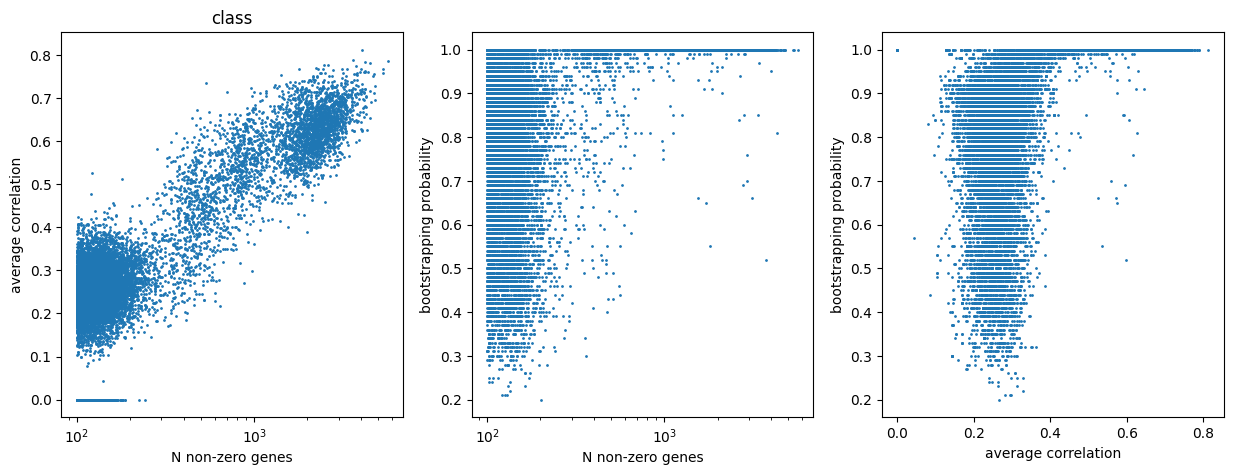

In [34]:
level = 'CCN20230722_CLAS'

cell_barcodes = raw_data.obs.index.values

# convert cell type mapping into a dict keyed on each cell's barcode
mapping_result = {c['cell_id']: c for c in json_results['results']}

# get an array of how many genes were measured with more than 0 counts in each cell
n_genes = (raw_data.X[()].toarray()>0).sum(axis=1)

# assemble arrays of the two QC metrics
avg_corr = np.array([mapping_result[b][level]['avg_correlation'] for b in cell_barcodes])
bootstrapping_prob = np.array([mapping_result[b][level]['bootstrapping_probability'] for b in cell_barcodes])

fig = plt.figure(figsize=(15,5))
corr_axis = fig.add_subplot(1,3,1)
prob_axis = fig.add_subplot(1,3,2)
corr_v_prob_axis = fig.add_subplot(1,3,3)

level_name = taxonomy_tree['hierarchy_mapper'][level]

corr_axis.set_title(level_name)
corr_axis.scatter(n_genes, avg_corr, s=1)
corr_axis.set_xlabel('N non-zero genes')
corr_axis.set_ylabel('average correlation')
corr_axis.set_xscale('log')

prob_axis.scatter(n_genes, bootstrapping_prob, s=1)
prob_axis.set_xlabel('N non-zero genes')
prob_axis.set_ylabel('bootstrapping probability')
prob_axis.set_xscale('log')

corr_v_prob_axis.scatter(avg_corr, bootstrapping_prob, s=1)
corr_v_prob_axis.set_xlabel('average correlation')
corr_v_prob_axis.set_ylabel('bootstrapping probability')

Here we see a strong correlation between the number of non-zero genes measured for a cell and its `avg_correlation` score. This makes sense. If not many genes were measured as expressing in a given cell, it will be harder to find a good fit for that cell in our cell type taxonomy. The correlation between non-zero genes and `bootstrapping_probability` is less strong, though we do see that, while a low number of non-zero genes does not necessarily imply a low `bootstrapping_probability`, a low `bootstrapping_probability` does seem to imply a low number of non-zero genes.

## UMAP plot

Below we demonstrate how to generate a UMAP of the unlabeled data and plot it, coloring the points according to the cell types assigned by MapMyCells.

First, define a helper function to generate and plot the embedding.

In [35]:
def plot_embedding(
        barcode_to_label,
        label_order,
        fontsize=15):
    """
    Generate and plot a UMAP embedding of the raw data.

    Parameters
    ----------
    barcode_to_label:
        A dict mapping cell barcodes to labels (only includes
        cells that we want included in the embedding)
    label_order:
        order in which we want labels to appear on the color map.
    fontsize:
        size of font to be used in legend

    Returns
    -------
    None
        generates and displays the plot of the embedding
    """

    level = 'CCN20230722_CLAS'
    reducer = umap.UMAP()

    _barcodes = raw_data.obs.index.values
    data = raw_data.X[()].toarray()

    filter_mask = np.zeros(data.shape[0], dtype=bool)
    for ii, b in enumerate(_barcodes):
        if b in barcode_to_label:
            filter_mask[ii] = True

    if not hasattr(plot_embedding, 'filter_mask'):
        plot_embedding.embedding =  None

    run_embedding = False
    if plot_embedding.embedding is None:
        run_embedding = True
    elif not np.array_equal(filter_mask, plot_embedding.filter_mask):
        run_embedding = True

    if run_embedding:
        plot_embedding.embedding = reducer.fit_transform(data[filter_mask, :])
        plot_embedding.filter_mask = filter_mask

    embedding = plot_embedding.embedding

    label_to_idx = {label:ii for ii, label in enumerate(label_order)}
    
    assignments = np.array(
        [
            label_to_idx[
                barcode_to_label[b]
            ] for b in _barcodes[filter_mask]
        ]
    )

    ticks = [ii for ii in range(len(label_order))]

    fig = plt.figure(figsize=(10,10))
    axis = fig.add_subplot(1,1,1)
    for label in label_order:
        cell_mask = (assignments==label_to_idx[label])
        axis.scatter(embedding[cell_mask, 0], embedding[cell_mask, 1], label=label, s=10)
    axis.legend(loc=0, fontsize=fontsize)

Let's just color the points by their class assigment, assigning classes with `Glut` in the name to one color, `GABA` to another, and all other classes their own color.

In [36]:
level = 'CCN20230722_CLAS'
corr_cut = 0.4

node_to_label = dict()
for node in taxonomy_tree[level]:
    name = taxonomy_tree['name_mapper'][level][node]['name']
    if 'Glut' in name:
        label = 'Glut'
    elif 'GABA' in name:
        label = 'GABA'
    else:
        label = name
    node_to_label[node] = label

barcode_to_label = dict()
for barcode in mapping_result:
    cell = mapping_result[barcode]
    if cell[level]['avg_correlation'] < corr_cut:
        continue
    barcode_to_label[barcode] = node_to_label[cell[level]['assignment']]

label_order = ['Glut', 'GABA']
for label in set(barcode_to_label.values()):
    if label not in label_order:
        label_order.append(label)

In [37]:
label_order

['Glut', 'GABA', '34 Immune', '33 Vascular', '30 Astro-Epen', '31 OPC-Oligo']

CPU times: user 1min 28s, sys: 1.55 s, total: 1min 30s
Wall time: 1min 5s


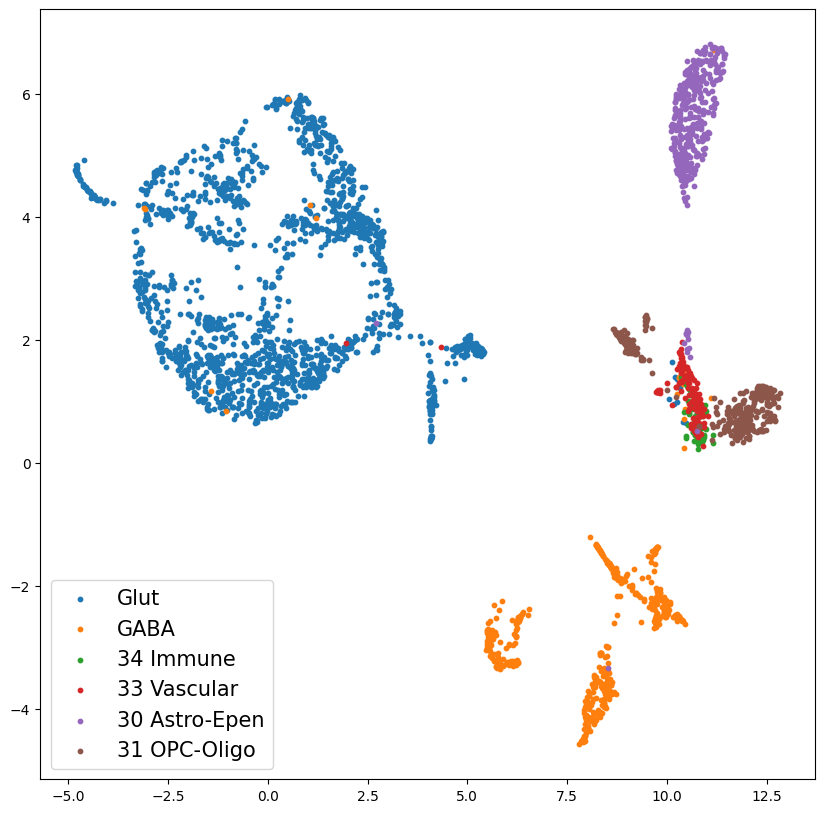

In [38]:
%%time
plot_embedding(barcode_to_label=barcode_to_label, label_order=label_order)

Now let's look at the same plot, coloring each individual `Glut` class separately.

In [39]:
node_to_label = dict()
for node in taxonomy_tree[level]:
    name = taxonomy_tree['name_mapper'][level][node]['name']
    if 'Glut' in name:
        idx = 0
        label = name
    else:
        label = 'Other'
    node_to_label[node] = label

barcode_to_label = dict()
for barcode in mapping_result:
    cell = mapping_result[barcode]
    if cell[level]['avg_correlation'] < corr_cut:
        continue
    barcode_to_label[barcode] = node_to_label[cell[level]['assignment']]

label_order = ['Other']
for label in set(barcode_to_label.values()):
    if label not in label_order:
        label_order.append(label)

CPU times: user 815 ms, sys: 690 ms, total: 1.51 s
Wall time: 1.54 s


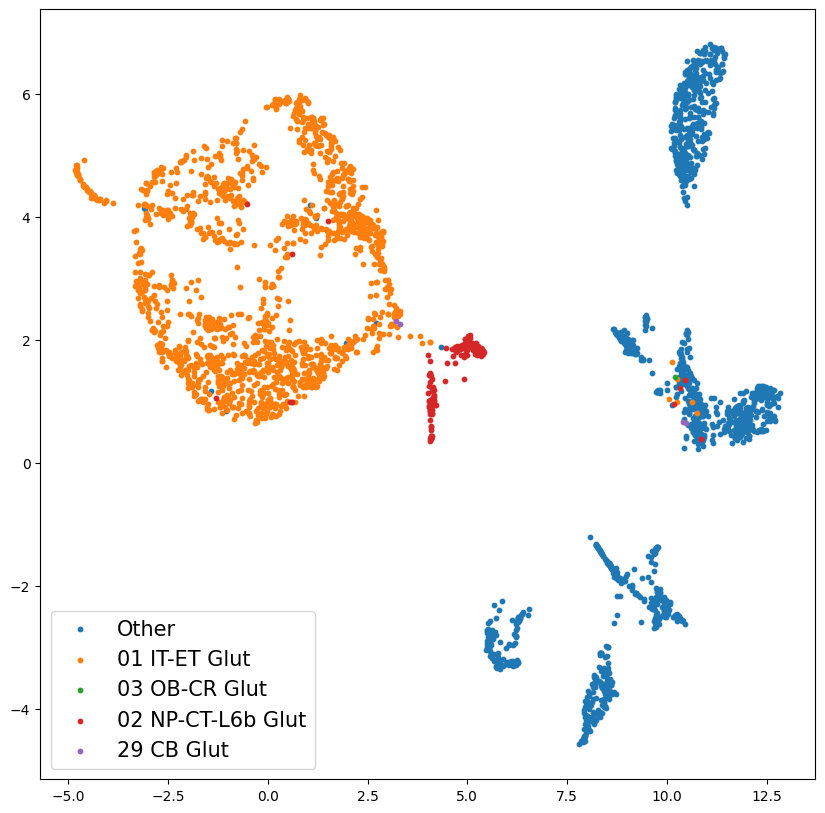

In [40]:
%%time
plot_embedding(barcode_to_label=barcode_to_label, label_order=label_order)

Look at the individual `GABA` classes.

In [41]:
node_to_label = dict()
for node in taxonomy_tree[level]:
    name = taxonomy_tree['name_mapper'][level][node]['name']
    if 'GABA' in name:
        idx = 0
        label = name
    else:
        label = 'Other'
    node_to_label[node] = label

barcode_to_label = dict()
for barcode in mapping_result:
    cell = mapping_result[barcode]
    if cell[level]['avg_correlation'] < corr_cut:
        continue
    barcode_to_label[barcode] = node_to_label[cell[level]['assignment']]

label_order = ['Other']
for label in set(barcode_to_label.values()):
    if label not in label_order:
        label_order.append(label)

CPU times: user 789 ms, sys: 646 ms, total: 1.44 s
Wall time: 1.46 s


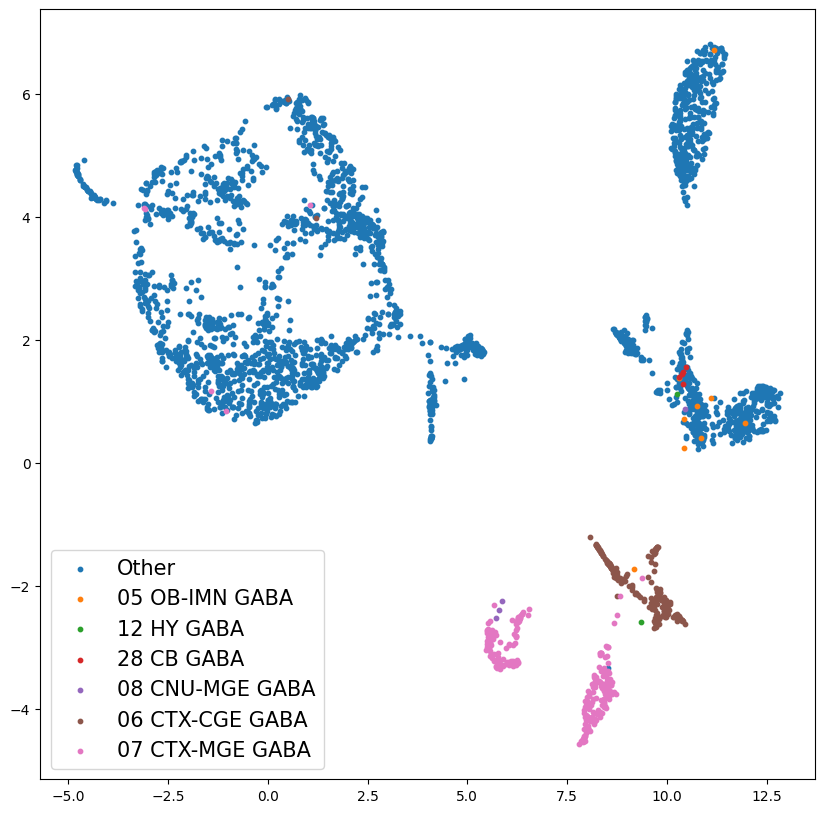

In [42]:
%%time
plot_embedding(barcode_to_label=barcode_to_label, label_order=label_order)

Now let's color by subclass, but only consider children of the `Glut` class `01 IT-ET Glut` (`CS20230722_CLAS_01`)

In [43]:
subclass_level = 'CCN20230722_SUBC'
class_level = 'CCN20230722_CLAS'
chosen_class = 'CS20230722_CLAS_01'
node_to_label = dict()
corr_cut = 0.4

for node in taxonomy_tree[class_level][chosen_class]:
    name = taxonomy_tree['name_mapper'][subclass_level][node]['name']
    node_to_label[node] = name

barcode_to_label = dict()
for barcode in mapping_result:
    cell = mapping_result[barcode]
    if cell[class_level]['avg_correlation'] < corr_cut:
        continue
    if cell[subclass_level]['avg_correlation'] < corr_cut:
        continue
    if cell[class_level]['assignment'] != chosen_class:
        continue
    barcode_to_label[barcode] = node_to_label[cell[subclass_level]['assignment']]

label_order =list(set(barcode_to_label.values()))
label_order.sort()

In [44]:
len(barcode_to_label)

1507

CPU times: user 27.6 s, sys: 1.17 s, total: 28.8 s
Wall time: 16.7 s


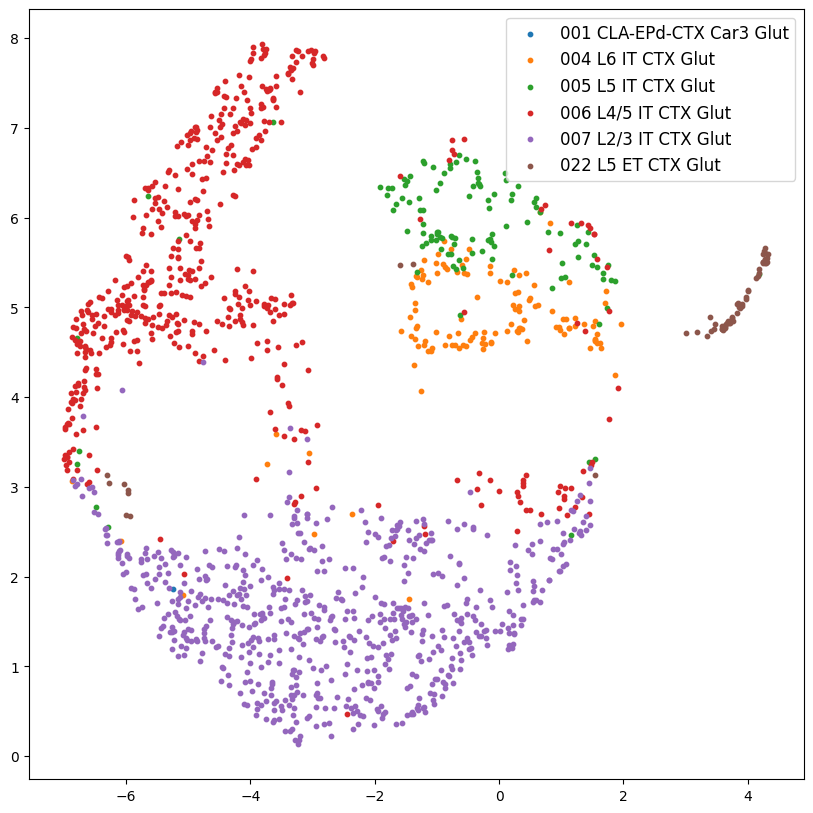

In [45]:
%%time
plot_embedding(barcode_to_label=barcode_to_label, label_order=label_order, fontsize=12)